In [1]:
from sklearn.metrics import accuracy_score
from sklearn import svm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
from operator import lt,ge
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
import time

In [2]:
class DecisionStump:
    #Weak learner implementation using Decision Stump
    def __init__(self, col=0, value=0, operator=lt, max_depth=1):
        self.col = col
        self.value = value
        self.operator = operator
        self.max_depth = 1

    def update(self, col=None, value=None, operator=None):
        if col is not None: self.col = col
        if value is not None: self.value = value
        if operator is not None: self.operator = operator

    def predict(self, X_train):
        return np.array([1 if self.operator(x, self.value) else -1 for x in X_train[:, self.col]])

    # Find an optimal value that can classify the dataset.
    def fit(self, X_train, y_train, data_weights, n_splits=100):
        n, d = X_train.shape
        min_err = np.inf

        for col in range(d):
            # return
            min_col_err, value, operator = self.fit_col(X_train[:, col], y_train, data_weights, n_splits)
            if min_col_err < min_err:
                min_err = min_col_err
                self.update(col, value, operator)

    # Fitting one-dimensional decision stump classifier.
    def fit_col(self, X_train, y_train, data_weights, n_splits):

        min_err, split_value, operator = np.inf, None, lt
        n_splits = min(n_splits, len(y_train) - 1)

        for value in np.linspace(min(X_train), max(X_train), n_splits, endpoint=False):
            prediction = [1 if x < value else -1 for x in X_train]
            indicator = np.not_equal(prediction, y_train)
            error_rate = np.dot(data_weights, indicator)
            if error_rate < min_err:
                min_err = error_rate
                split_value = value
                operator = lt

            error_rate = np.dot(data_weights, ~indicator)
            if error_rate < min_err:
                min_err = error_rate
                split_value = value
                operator = ge

        return min_err, split_value, operator

In [3]:
class Adaboost:
    def __init__(self, weak_learners=None, beta_ms=None):
        self.weak_learners = weak_learners if weak_learners is not None else []
        self.beta_ms = beta_ms if beta_ms is not None else []
    
    def train(self, X_train, y_train, X_test, y_test):
        # Maximum number of weak learners to be used in Adaboost
        maximum_weak_learners = 100

        # Train and test error
        train_error = []
        test_error = []
        for m in range(0, maximum_weak_learners ):
            print("Training Adaboost with weak learners %d" %(m + 1) )
            self.append_learner(X_train, y_train)
            train_error.append(self.prediction_error(X_train, y_train))
            test_error.append(self.prediction_error(X_test, y_test))
            
        # Compare error rate vs number of iterations
        error_rate_iteration_plot(train_error, test_error)
        print("Initial Training Error=%.4f  Testing Error= %.4f " % (train_error[0], test_error[0]))
        print("Final Training Error=%.4f  Testing Error= %.4f " % (train_error[-1], test_error[-1]))
        
    
    def append_learner(self, X_train, y_train, weak_learner_selection=DecisionStump):
        #weak_learner_selection=DecisionStump
        #weak_learner_selection=DecisionTreeClassifier
        n, d = X_train.shape
        data_weights = np.ones(n) / n

        for l, w in zip(self.weak_learners, self.beta_ms):
            weak_learner_prediction = l.predict(X_train)
            weak_learner_indicator = np.not_equal(weak_learner_prediction, y_train)
            error_rates = np.dot(data_weights, weak_learner_indicator) / np.sum(data_weights)
            error_rates = max(1e-8, error_rates)  # Avoid division by zero
            beta_m = 0.5*np.log((1 - error_rates) / error_rates)

            # Update data weighting coefficient for next learner
            data_weights = [sw * np.exp(-beta_m * pow(-1,im)) for sw, im in zip(data_weights, weak_learner_indicator)]
            normalization_constant = np.sum(data_weights)
            normalization_constant = max(1e-8, normalization_constant)
            data_weights = [sw/normalization_constant for sw in data_weights]

        new_weak_learner = weak_learner_selection(max_depth=1)
        new_weak_learner.fit(X_train, y_train, data_weights)
        new_weak_learner_prediction = new_weak_learner.predict(X_train)
        new_weak_learner_indicator = np.not_equal(new_weak_learner_prediction, y_train)
        new_error_rates = np.dot(data_weights, new_weak_learner_indicator) / np.sum(data_weights)
        new_error_rates = max(1e-8, new_error_rates)  # Avoid division by zero
        new_beta_m = 0.5*np.log((1 - new_error_rates) / new_error_rates)
        self.weak_learners.append(new_weak_learner)
        self.beta_ms.append(new_beta_m)

    # predictions
    def predict(self, X):
        n, d = X.shape
        pred = np.zeros(n)
        for l, w in zip(self.weak_learners, self.beta_ms):
            weak_learner_prediction = l.predict(X)
            pred += w * weak_learner_prediction

        pred = np.array([1 if p > 0 else -1 for p in pred])
        return pred

    #  Calculate the error rate in prediction result
    def prediction_error(self, X, Y):
        pred = self.predict(X)
        error = np.mean(np.not_equal(pred, Y))
        return error

In [4]:
def error_rate_iteration_plot(er_train, er_test):
    #plot Error rate vs number of iterations
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,600,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

In [5]:
def statistic_analysis(clf,X,Y):
    pred = clf.predict(X)
    true_pos = ((pred == 1) & (Y == 1)).sum()
    true_neg = ((pred == -1) & (Y == -1)).sum()
    false_pos = ((pred == 1) & (Y == -1)).sum()
    false_neg = ((pred == -1) & (Y == 1)).sum()
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_neg + false_pos)
    prec = true_pos/ (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    F1Score = 2*(recall * prec) / (recall + prec)
    print('True Positive:',true_pos)
    print('True Negative:',true_neg)
    print('False Positive:',false_pos)
    print('False Negative:',false_neg)
    print('Accuracy:', accuracy)
    print('Precision:', prec)
    print('Recall:', recall)
    print('F1 Score:', F1Score)

In [6]:
def y_type(Y):
    #transfer Y to a 1-dimensional array
    new_y = []
    for i in range(len(Y)):
        new_y.append(Y[i])
    return np.array(new_y)


Training Adaboost with weak learners 1
Training Adaboost with weak learners 2
Training Adaboost with weak learners 3
Training Adaboost with weak learners 4
Training Adaboost with weak learners 5
Training Adaboost with weak learners 6
Training Adaboost with weak learners 7
Training Adaboost with weak learners 8
Training Adaboost with weak learners 9
Training Adaboost with weak learners 10
Training Adaboost with weak learners 11
Training Adaboost with weak learners 12
Training Adaboost with weak learners 13
Training Adaboost with weak learners 14
Training Adaboost with weak learners 15
Training Adaboost with weak learners 16
Training Adaboost with weak learners 17
Training Adaboost with weak learners 18
Training Adaboost with weak learners 19
Training Adaboost with weak learners 20
Training Adaboost with weak learners 21
Training Adaboost with weak learners 22
Training Adaboost with weak learners 23
Training Adaboost with weak learners 24
Training Adaboost with weak learners 25
Training 

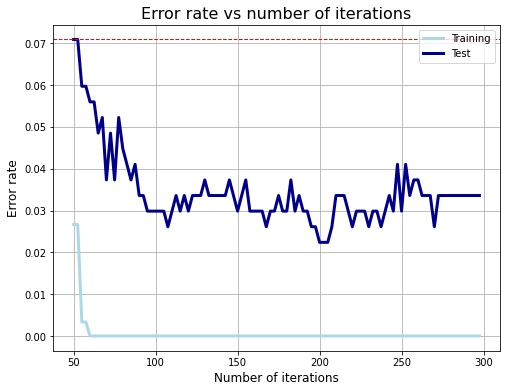

In [7]:
if __name__ == '__main__':
    # Import the dataset
    datasets = pd.read_csv('wdbc_data.csv')
    Y = datasets.iloc[:, 1].values
    # Tramsfer labels to {-1,1}
    Y[Y == 'M'] = -1
    Y[Y == 'B'] = 1
    Y=y_type(Y)
    X = datasets.iloc[:, 2:].values
    
    X_train = X[0:300, :]
    y_train = Y[0:300]
    X_test = X[300:, :]
    y_test = Y[300:]
    
    # Training Adaboost with weak learners
    adaboost_classfier = Adaboost()
    time_start=time.time()
    adaboost_classfier.train(X_train, y_train, X_test, y_test)
    time_end=time.time()
    print('Adaboost time cost',time_end-time_start,'s')

    
    #Statistic Analysis of trained model
    print("Train Data Statistic Analysis:")
    statistic_analysis(adaboost_classfier,X_train,y_train)
    print("Test Data Statistic Analysis:")
    statistic_analysis(adaboost_classfier,X_test,y_test)
    
    
    # SVM
    svm_classifier = svm.SVC(gamma='scale', probability=True)
    time_start=time.time()
    svm_classifier.fit(X_train, y_train)
    time_end=time.time()
    print('SVM training time cost',time_end-time_start,'s')
    
    #Inbuild package
    ab_classfier = AdaBoostClassifier(n_estimators=100, learning_rate=1)
    gb_classfier = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_features=2, max_depth=3, random_state=0)
    
    time_start=time.time()
    adaboost_classfier_ada = ab_classfier.fit(X_train, y_train)
    time_end=time.time()
    print('AdaboostClassifier training time cost',time_end-time_start,'s')
    
    time_start=time.time()
    adaboost_classfier_gradient = gb_classfier.fit(X_train, y_train)
    time_end=time.time()
    print('GradientBoostingClassifier training time cost',time_end-time_start,'s')

    time_start=time.time()
    test_pred = adaboost_classfier.predict(X_test)
    time_end=time.time()
    print('Adaboost test time cost',time_end-time_start,'s')
    
    time_start=time.time()
    test_pred_1 = adaboost_classfier_ada.predict(X_test)
    time_end=time.time()
    print('AdaboostClassifier test time cost',time_end-time_start,'s')
    
    time_start=time.time()
    test_pred_2 = adaboost_classfier_gradient.predict(X_test)
    time_end=time.time()
    print('GradientBoostingClassifier test time cost',time_end-time_start,'s')
    
    time_start=time.time()
    test_pred_3 = svm_classifier.predict(X_test)
    time_end=time.time()
    print('SVM test time cost',time_end-time_start,'s')

    print("Accuracy score of SVM classifier : ", accuracy_score(y_test, svm_classifier.predict(X_test)))
    print("Accuracy for AdaBoostClassifier:", metrics.accuracy_score(y_test, test_pred_1))
    print("Accuracy for GradientBoostingClassifier:", metrics.accuracy_score(y_test, test_pred_2))
    
    #output the predicted result
    np.savetxt('test_pred.csv', test_pred, delimiter = ',')
    np.savetxt('test_pred_ada.csv', test_pred_1, delimiter = ',')
    np.savetxt('test_pred_gradient.csv', test_pred_2, delimiter = ',')
    np.savetxt('test_pred_SVM.csv', test_pred_3, delimiter = ',')
